# Linear Regression - GMST

In [1]:
import datetime as dt 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from utils import *

# from eofs.xarray import Eof

In [2]:
# train_files = [ "historical", "ssp585", "ssp126", "ssp370", ]
# Y = create_predictdand_data(train_files) # Already changes units of precipitation
Y = xr.open_dataset('/data/i4anders/Models/y_train/y_train.nc')

In [3]:
Y.compute()

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, year: 423)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables:
    tas      (year, lat, lon) float32 -0.1424 -0.1424 -0.1424 ... 16.79 16.79
    pr       (year, lat, lon) float32 0.000513 0.000513 ... 0.6601 0.6604
    huss     (year, lat, lon) float32 -1.108e-06 -1.108e-06 ... 0.001881
    hurs     (year, lat, lon) float32 0.09258 0.09261 0.09261 ... -14.19 -14.19
    rlds     (year, lat, lon) float32 0.9069 0.9063 0.9063 ... 77.96 77.96 77.96
    rsds     (year, lat, lon) float32 -1.53 -1.529 -1.529 ... -41.09 -41.09
    sfcWind  (year, lat, lon) float32 -0.03228 -0.03229 -0.03229 ... 1.407 1.407
    ps       (year, lat, lon) float32 -117.7 -117.7 -117.7 ... -205.6 -205.6

In [4]:
X = xr.concat([xr.open_dataset('/data/i4anders/inputs/inputs_historical.nc'), xr.open_dataset('/data/i4anders/inputs/inputs_ssp126.nc'),xr.open_dataset('/data/i4anders/inputs/inputs_ssp370.nc'),xr.open_dataset('/data/i4anders/inputs/inputs_ssp585.nc')], dim='time')

In [5]:
X = X.rename({'time':'year'})
X["year"]=np.arange(1,424) 
Y["year"]=np.arange(1,424)

In [6]:
weights = np.cos(np.deg2rad(Y.lat))
global_mean_temp = Y['tas'].weighted(weights).mean(['lat', 'lon']).to_pandas()

def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data.mean()

In [7]:
y_inp_tas=Y["tas"].stack(dim=["lat", "lon"])
y_inp_pr=Y["pr"].stack(dim=["lat", "lon"])
y_inp_huss=Y["huss"].stack(dim=["lat", "lon"])
y_inp_hurs=Y["hurs"].stack(dim=["lat", "lon"])
y_inp_rlds=Y["rlds"].stack(dim=["lat", "lon"])
y_inp_rsds=Y["rsds"].stack(dim=["lat", "lon"])
y_inp_sfcWind=Y["sfcWind"].stack(dim=["lat", "lon"])
y_inp_ps=Y["ps"].stack(dim=["lat", "lon"])

In [8]:
reg0 = LinearRegression(fit_intercept=False)
reg1 = LinearRegression(fit_intercept=False)
reg2 = LinearRegression(fit_intercept=False)
reg3 = LinearRegression(fit_intercept=False)
reg4 = LinearRegression(fit_intercept=False)
reg5 = LinearRegression(fit_intercept=False)
reg6 = LinearRegression(fit_intercept=False)
reg7 = LinearRegression(fit_intercept=False)

lr_tas = reg0.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_tas)
lr_pr = reg1.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_pr)
lr_huss = reg2.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_huss)
lr_hurs = reg3.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_hurs)
lr_rlds = reg4.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_rlds)
lr_rsds = reg5.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_rsds)
lr_sfcWind = reg6.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_sfcWind)
lr_ps = reg7.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_ps)

In [9]:
# Testing on ssp245, already imported 245 for plotting above
test_Y = xr.open_dataset('/data/climate-analytics-lab-shared//ClimateBench/CESM2_processed/outputs_ssp245.nc').mean(['month', 'member']).transpose('year', 'lat', 'lon')
test_X = xr.open_dataset('/data/i4anders/inputs/inputs_ssp245.nc').compute()

In [10]:
test_X=test_X.rename({'time':'year'})

In [11]:
test_Y['pr'] *= 86400

In [12]:
test_X

<xarray.Dataset>
Dimensions:    (year: 86, longitude: 144, latitude: 96)
Coordinates:
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * year       (year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
Data variables:
    CO2        (year) float64 1.536e+03 1.572e+03 ... 4.51e+03 4.524e+03
    SO2        (year, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CH4        (year) float64 0.3737 0.3737 0.3737 ... 0.281 0.2807 0.2803
    BC         (year, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [13]:
test_Y.compute()

<xarray.Dataset>
Dimensions:  (year: 86, lat: 192, lon: 288)
Coordinates:
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    tas      (year, lat, lon) float32 1.339 1.339 1.339 ... 9.46 9.46 9.459
    pr       (year, lat, lon) float32 0.01312 0.01312 0.01312 ... 0.1616 0.1615
    huss     (year, lat, lon) float32 9.854e-06 9.854e-06 ... 0.0008405
    hurs     (year, lat, lon) float32 0.1634 0.1634 0.1634 ... -6.797 -6.797
    rlds     (year, lat, lon) float32 4.132 4.132 4.132 ... 43.28 43.28 43.28
    rsds     (year, lat, lon) float32 0.6355 0.6353 0.6353 ... -20.81 -20.81
    sfcWind  (year, lat, lon) float32 -0.1045 -0.1045 -0.1045 ... 0.8908 0.8907
    ps       (year, lat, lon) float32 -137.5 -137.5 -137.5 ... 15.88 15.88 15.88

In [14]:
tas_truth = test_Y["tas"]
pr_truth = test_Y["pr"]
huss_truth = test_Y["huss"]
hurs_truth = test_Y["hurs"]
rlds_truth = test_Y["rlds"]
rsds_truth = test_Y["rsds"]
sfcWind_truth = test_Y["sfcWind"]
ps_truth = test_Y["ps"]

In [15]:
test_inputs = test_Y['tas'].weighted(weights).mean(['lat', 'lon']).to_pandas().rolling(10, min_periods=1).mean()

In [16]:
test_inputs

year
2015    1.301202
2016    1.212808
2017    1.167027
2018    1.153813
2019    1.150449
          ...   
2096    3.338427
2097    3.361185
2098    3.374997
2099    3.391313
2100    3.412900
Length: 86, dtype: float64

In [17]:
m_out_t = lr_tas.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_precip = lr_pr.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_hus = lr_huss.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_hur = lr_hurs.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_rl = lr_rlds.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_rs = lr_rsds.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_sfc = lr_sfcWind.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_p = lr_ps.predict(test_inputs.to_numpy()[:, np.newaxis])

m_out_tas = m_out_t.reshape(86, 192, 288)
m_out_pr = m_out_precip.reshape(86, 192, 288)
m_out_huss = m_out_hus.reshape(86, 192, 288)
m_out_hurs = m_out_hur.reshape(86, 192, 288)
m_out_rlds = m_out_rl.reshape(86, 192, 288)
m_out_rsds = m_out_rs.reshape(86, 192, 288)
m_out_sfcWind = m_out_sfc.reshape(86, 192, 288)
m_out_ps = m_out_p.reshape(86, 192, 288)

In [18]:
xr_output=xr.Dataset(coords={'year': test_Y.year.values, 'lat': test_Y.lat.values, 'lon': test_Y.lon.values})
xr_output["tas"]=(['time', 'lat', 'lon'],  m_out_tas)
xr_output["pr"]=(['time', 'lat', 'lon'],  m_out_pr)
xr_output["huss"]=(['time', 'lat', 'lon'],  m_out_huss)
xr_output["hurs"]=(['time', 'lat', 'lon'],  m_out_hurs)
xr_output["rlds"]=(['time', 'lat', 'lon'],  m_out_rlds)
xr_output["rsds"]=(['time', 'lat', 'lon'],  m_out_rsds)
xr_output["sfcWind"]=(['time', 'lat', 'lon'],  m_out_sfcWind)
xr_output["ps"]=(['time', 'lat', 'lon'],  m_out_ps)

In [19]:
print('tas: Near Surface Air Temperature')
print(f"RMSE 2080-2100: {get_rmse(tas_truth[65:], m_out_tas[65:])}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], m_out_tas[35:])}")
print("\n")

print('pr: Precipitation')
print(f"RMSE 2080-2100: {get_rmse(pr_truth[65:], m_out_pr[65:])}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[35:], m_out_pr[35:])}")
print("\n")

tas: Near Surface Air Temperature
RMSE 2080-2100: 0.44220015197080687
RMSE 2050-2100: 0.42887550355826076


pr: Precipitation
RMSE 2080-2100: 0.568244748190077
RMSE 2050-2100: 0.56794481077481




In [20]:
print('huss: Near Surface Specific Humidity')
print(f"RMSE 2080-2100: {get_rmse(huss_truth[65:], m_out_huss[65:])}")
print(f"RMSE 2050-2100: {get_rmse(huss_truth[35:], m_out_huss[35:])}")
print("\n")

print('hurs: Near Surface Relative Humidity')
print(f"RMSE 2080-2100: {get_rmse(hurs_truth[65:], m_out_hurs[65:])}")
print(f"RMSE 2050-2100: {get_rmse(hurs_truth[35:], m_out_hurs[35:])}")
print("\n")

huss: Near Surface Specific Humidity
RMSE 2080-2100: 0.0002918302799472132
RMSE 2050-2100: 0.00027962707604655177


hurs: Near Surface Relative Humidity
RMSE 2080-2100: 0.9755387233511522
RMSE 2050-2100: 0.9739690601543282




In [21]:
print('rlds: Surface Downwelling Longwave Radiation')
print(f"RMSE 2080-2100: {get_rmse(rlds_truth[65:], m_out_rlds[65:])}")
print(f"RMSE 2050-2100: {get_rmse(rlds_truth[35:], m_out_rlds[35:])}")
print("\n")

print('rsds: Surface Downwelling Shortwave Radiation')
print(f"RMSE 2080-2100: {get_rmse(rsds_truth[65:], m_out_rsds[65:])}")
print(f"RMSE 2500-2100: {get_rmse(rsds_truth[35:], m_out_rsds[35:])}")
print("\n")

rlds: Surface Downwelling Longwave Radiation
RMSE 2080-2100: 2.7357655996598615
RMSE 2050-2100: 2.6842921671639997


rsds: Surface Downwelling Shortwave Radiation
RMSE 2080-2100: 4.845428770251083
RMSE 2500-2100: 4.625581292892578




In [22]:
print('sfcWind: Near-Surface wind speed')
print(f"RMSE 2080-2100: {get_rmse(sfcWind_truth[65:], m_out_sfcWind[65:])}")
print(f"RMSE 2050-2100: {get_rmse(sfcWind_truth[35:], m_out_sfcWind[35:])}")
print("\n")

print('ps: surface air pressure')
print(f"RMSE 2080-2100: {get_rmse(ps_truth[65:], m_out_ps[65:])}")
print(f"RMSE 2050-2100: {get_rmse(ps_truth[35:], m_out_ps[35:])}")
print("\n")

sfcWind: Near-Surface wind speed
RMSE 2080-2100: 0.2039786401651007
RMSE 2050-2100: 0.2057353551802626


ps: surface air pressure
RMSE 2080-2100: 78.34655201594407
RMSE 2050-2100: 77.1559372443647




### Plotting scenarios and predicted

In [23]:
tas_out = xr.DataArray(m_out_tas, dims=('year', 'lat', 'lon'))
x = range(2015,2101)

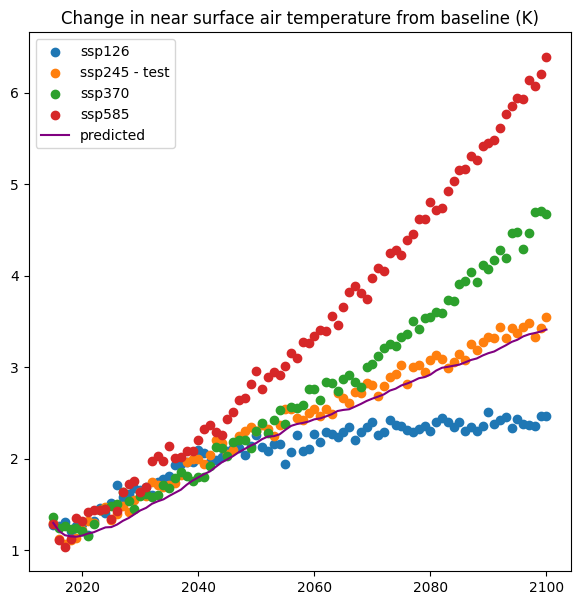

In [83]:
plt.figure(figsize=(7, 7))
plt.scatter(x, Y['tas'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, test_Y['tas'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, Y['tas'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.scatter(x, Y['tas'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.plot(x, tas_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in near surface air temperature from baseline (K)")
plt.legend()

plt.savefig('gmst_tas.jpg', dpi='figure', format=None)

In [25]:
xr_output = xr_output.rename({'time':'year'})


In [26]:
xr_output

<xarray.Dataset>
Dimensions:  (year: 86, lat: 192, lon: 288)
Coordinates:
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    tas      (year, lat, lon) float64 2.111 2.111 2.111 ... 9.415 9.415 9.414
    pr       (year, lat, lon) float64 0.03644 0.03644 0.03644 ... 0.2366 0.2366
    huss     (year, lat, lon) float64 4.053e-05 4.053e-05 ... 0.0008452
    hurs     (year, lat, lon) float64 -0.1571 -0.1571 -0.1571 ... -6.929 -6.929
    rlds     (year, lat, lon) float64 7.583 7.582 7.583 7.582 ... 47.2 47.2 47.2
    rsds     (year, lat, lon) float64 -3.049 -3.049 -3.049 ... -25.46 -25.46
    sfcWind  (year, lat, lon) float64 0.05163 0.05163 0.05163 ... 0.8072 0.8072
    ps       (year, lat, lon) float64 87.09 87.09 87.09 ... -167.4 -167.4 -167.4

[Text(0.5, 1.0, 'Difference')]

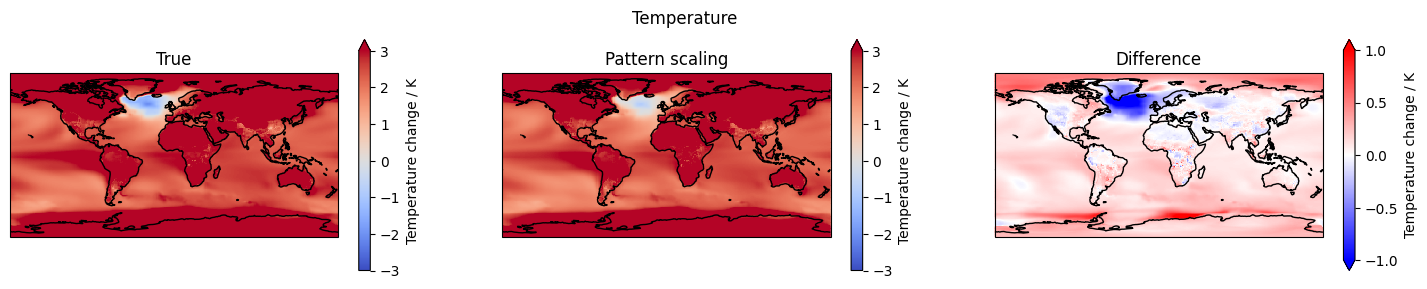

In [27]:
## Temperature
import cartopy.crs as ccrs

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
tas_truth.sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmax=3,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
xr_output["tas"].sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmax=3,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = tas_truth - xr_output["tas"]
plt.subplot(133, projection=proj)
difference.sel(year=slice(2050,None)).mean('year').plot(cmap="bwr", vmax=1,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [28]:
print(f"RMSE: {get_rmse(tas_truth[65:], m_out_tas[65:])}")
print(f"RMSE: {get_rmse(tas_truth[35:], m_out_tas[35:])}")

RMSE: 0.44220015197080687
RMSE: 0.42887550355826076


### `pr`

In [29]:
pr_out = xr.DataArray(m_out_pr, dims=('year', 'lat', 'lon'))

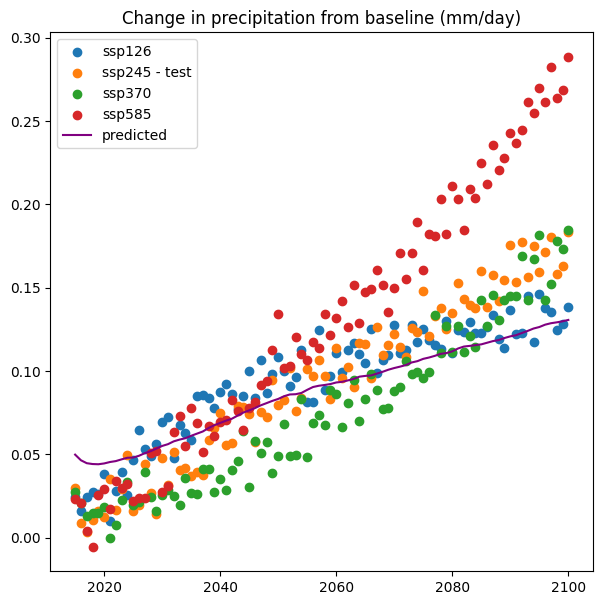

In [94]:
plt.figure(figsize=(7, 7))
plt.scatter(x, Y['pr'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, test_Y['pr'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, Y['pr'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.scatter(x, Y['pr'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.plot(x, pr_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in precipitation from baseline (mm/day)")
plt.legend()
plt.savefig('gmst_pr.jpg', dpi='figure', format=None)

In [31]:
print(f"RMSE: {get_rmse(pr_truth[65:], m_out_pr[65:])}")
print(f"RMSE: {get_rmse(pr_truth[35:], m_out_pr[35:])}")

RMSE: 0.568244748190077
RMSE: 0.56794481077481


[Text(0.5, 1.0, 'Difference')]

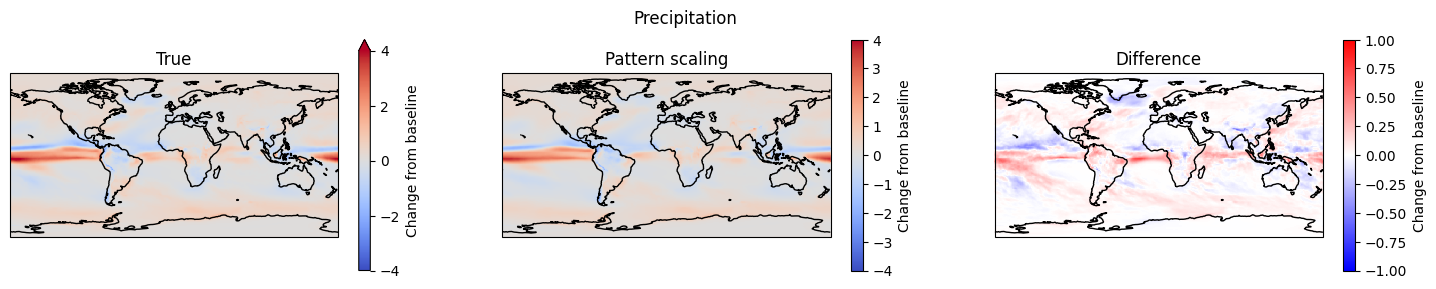

In [62]:
## Precipitation
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Precipitation')

# Test
plt.subplot(131, projection=proj)
pr_truth.sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -4, vmax=4,
                              cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
xr_output["pr"].sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -4, vmax=4,
                       cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = pr_truth - xr_output["pr"]
plt.subplot(133, projection=proj)
difference.sel(year=slice(2050,None)).mean('year').plot(cmap="bwr", vmin = -1, vmax=1,
                cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

### `huss`

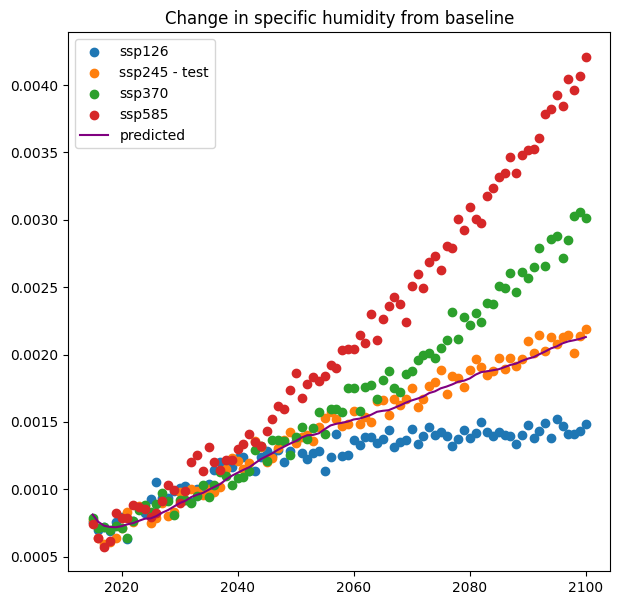

In [93]:
huss_out = xr.DataArray(m_out_huss, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(7, 7))
plt.scatter(x, Y['huss'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, test_Y['huss'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, Y['huss'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.scatter(x, Y['huss'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.plot(x, huss_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in specific humidity from baseline")
plt.legend()
plt.savefig('gmst_huss.jpg', dpi='figure', format=None)

In [53]:
print(f"RMSE: {get_rmse(huss_truth[65:], m_out_huss[65:])}")
print(f"RMSE: {get_rmse(huss_truth[35:], m_out_huss[35:])}")

RMSE: 0.0002918302799472132
RMSE: 0.00027962707604655177


[Text(0.5, 1.0, 'Difference')]

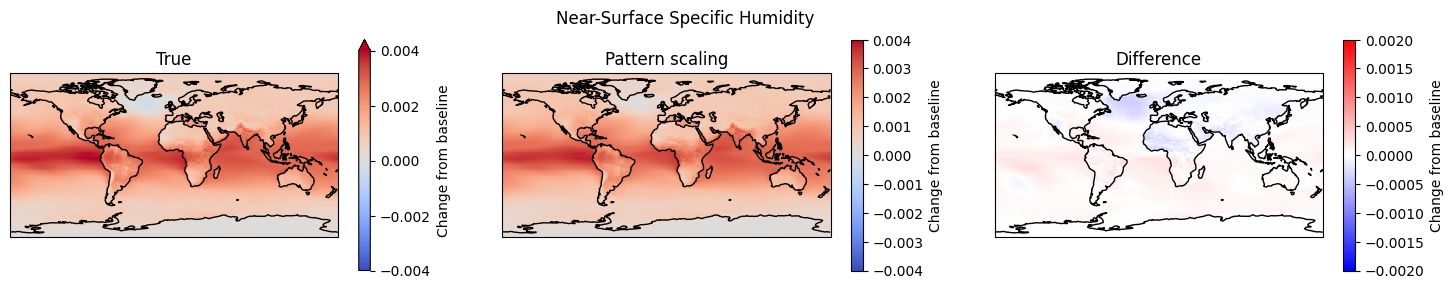

In [63]:
## Specific Humidity
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Near-Surface Specific Humidity')

# Test
plt.subplot(131, projection=proj)
huss_truth.sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -0.004, vmax=0.004,
                              cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
xr_output["huss"].sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm",vmin = -0.004, vmax=0.004,
                       cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = huss_truth - xr_output["huss"]
plt.subplot(133, projection=proj)
difference.sel(year=slice(2050,None)).mean('year').plot(cmap="bwr", vmin = -0.002, vmax=0.002,
                cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

### `hurs`

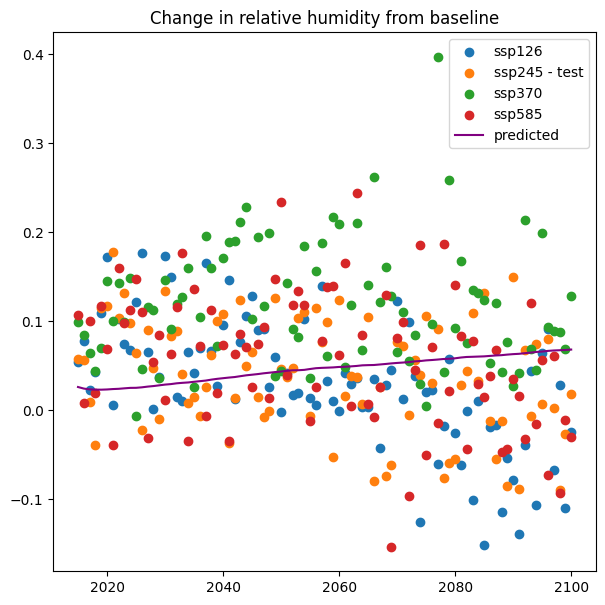

In [92]:
hurs_out = xr.DataArray(m_out_hurs, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(7, 7))
plt.scatter(x, Y['hurs'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, test_Y['hurs'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, Y['hurs'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.scatter(x, Y['hurs'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.plot(x, hurs_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in relative humidity from baseline")
plt.legend()
plt.savefig('gmst_hurs.jpg', dpi='figure', format=None)

In [37]:
print(f"RMSE: {get_rmse(hurs_truth[65:], m_out_hurs[65:])}")
print(f"RMSE: {get_rmse(hurs_truth[35:], m_out_hurs[35:])}")

RMSE: 0.9755387233511522
RMSE: 0.9739690601543282


[Text(0.5, 1.0, 'Difference')]

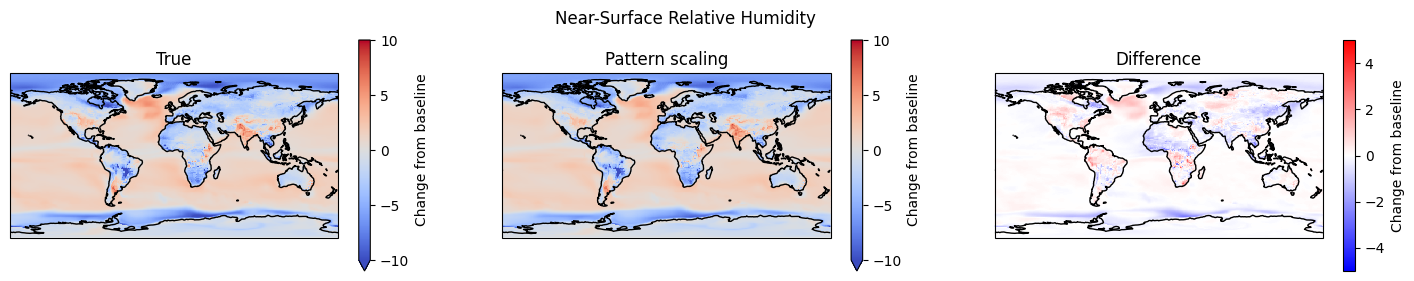

In [64]:
## Relative Humidity
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Near-Surface Relative Humidity')

# Test
plt.subplot(131, projection=proj)
hurs_truth.sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -10, vmax=10,
                              cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
xr_output["hurs"].sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -10, vmax=10,
                       cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = hurs_truth - xr_output["hurs"]
plt.subplot(133, projection=proj)
difference.sel(year=slice(2050,None)).mean('year').plot(cmap="bwr",vmin = -5, vmax=5,
                cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

### `rlds`

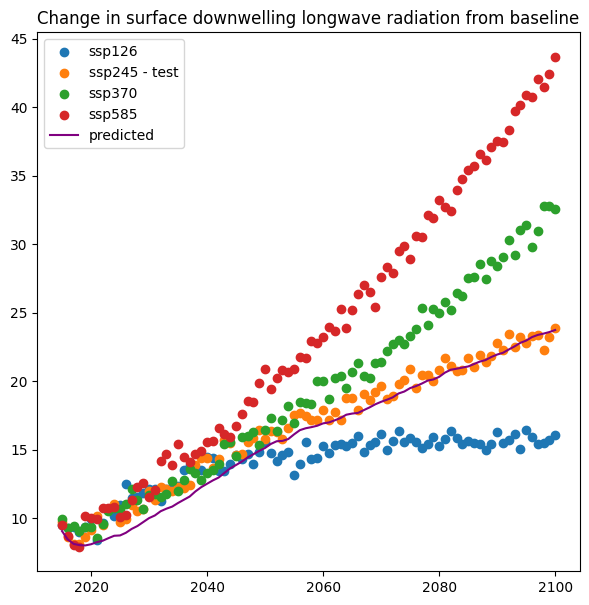

In [91]:
rlds_out = xr.DataArray(m_out_rlds, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(7, 7))
plt.scatter(x, Y['rlds'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, test_Y['rlds'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, Y['rlds'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.scatter(x, Y['rlds'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.plot(x, rlds_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in surface downwelling longwave radiation from baseline")
plt.legend()
plt.savefig('gmst_rlds.jpg', dpi='figure', format=None)

In [40]:
print(f"RMSE: {get_rmse(rlds_truth[65:], m_out_rlds[65:])}")
print(f"RMSE: {get_rmse(rlds_truth[35:], m_out_rlds[35:])}")

RMSE: 2.7357655996598615
RMSE: 2.6842921671639997


[Text(0.5, 1.0, 'Difference')]

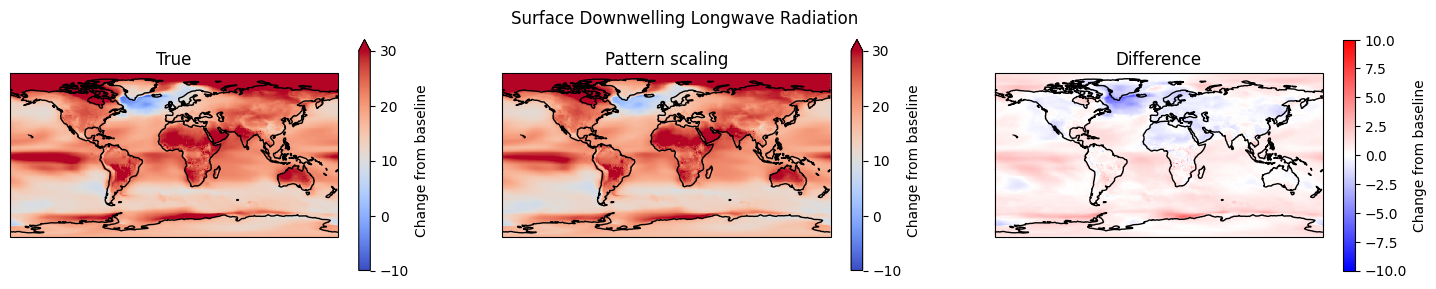

In [65]:
## Surface Downwelling Longwave Radiation
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Surface Downwelling Longwave Radiation')

# Test
plt.subplot(131, projection=proj)
rlds_truth.sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -10, vmax=30,
                              cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
xr_output["rlds"].sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -10, vmax=30,
                       cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = rlds_truth - xr_output["rlds"]
plt.subplot(133, projection=proj)
difference.sel(year=slice(2050,None)).mean('year').plot(cmap="bwr", vmin = -10, vmax=10,
                cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

### `rsds`

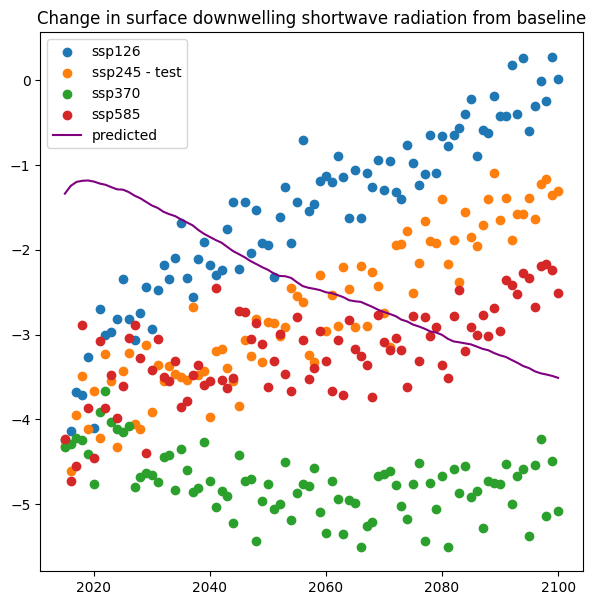

In [90]:
rsds_out = xr.DataArray(m_out_rsds, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(7, 7))
plt.scatter(x, Y['rsds'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, test_Y['rsds'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, Y['rsds'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.scatter(x, Y['rsds'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.plot(x, rsds_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in surface downwelling shortwave radiation from baseline")
plt.legend()
plt.savefig('gmst_rsds.jpg', dpi='figure', format=None)

In [57]:
print(f"RMSE: {get_rmse(rsds_truth[65:], m_out_rsds[65:])}")
print(f"RMSE: {get_rmse(rsds_truth[35:], m_out_rsds[35:])}")

RMSE: 4.845428770251083
RMSE: 4.625581292892578


[Text(0.5, 1.0, 'Difference')]

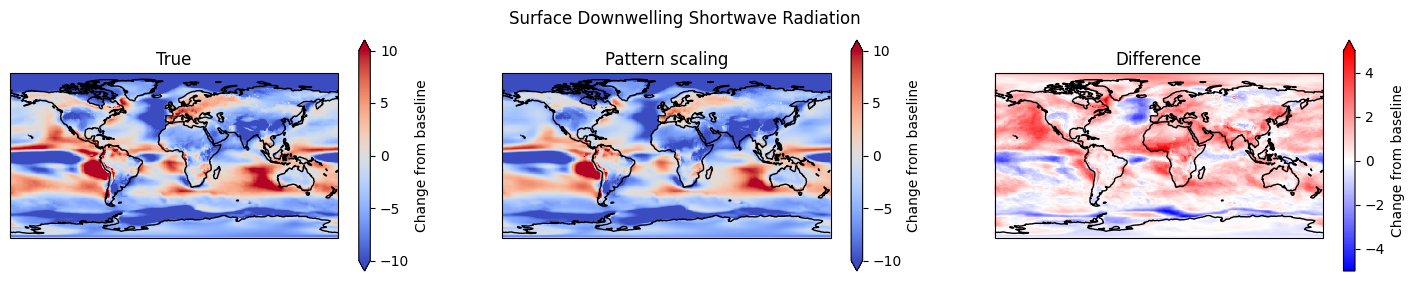

In [66]:
## Surface Downwelling Shortwave Radiation
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Surface Downwelling Shortwave Radiation')

# Test
plt.subplot(131, projection=proj)
rsds_truth.sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -10, vmax=10,
                              cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
xr_output["rsds"].sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -10, vmax=10,
                       cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = rsds_truth - xr_output["rsds"]
plt.subplot(133, projection=proj)
difference.sel(year=slice(2050,None)).mean('year').plot(cmap="bwr", vmin = -5, vmax=5,
                cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

### `sfcWind`

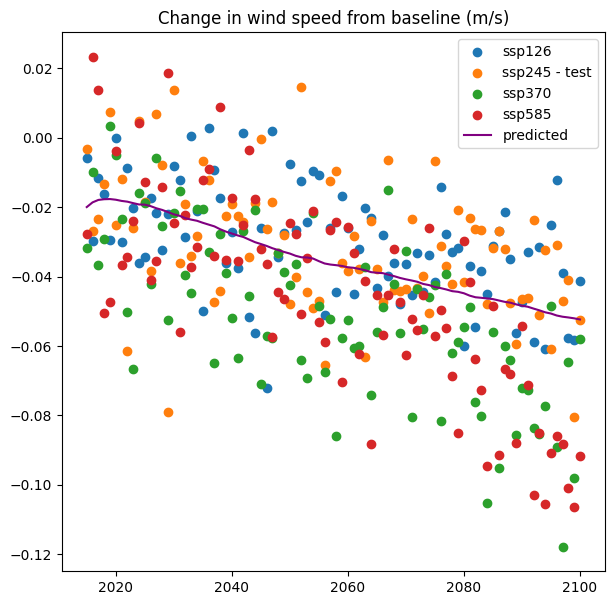

In [89]:
wind_out = xr.DataArray(m_out_sfcWind, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(7, 7))
plt.scatter(x, Y['sfcWind'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, test_Y['sfcWind'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, Y['sfcWind'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.scatter(x, Y['sfcWind'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.plot(x, wind_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in wind speed from baseline (m/s)")
plt.legend()
plt.savefig('gmst_wind.jpg', dpi='figure', format=None)

In [46]:
print(f"RMSE: {get_rmse(sfcWind_truth[65:], m_out_sfcWind[65:])}")
print(f"RMSE: {get_rmse(sfcWind_truth[35:], m_out_sfcWind[35:])}")

RMSE: 0.2039786401651007
RMSE: 0.2057353551802626


[Text(0.5, 1.0, 'Difference')]

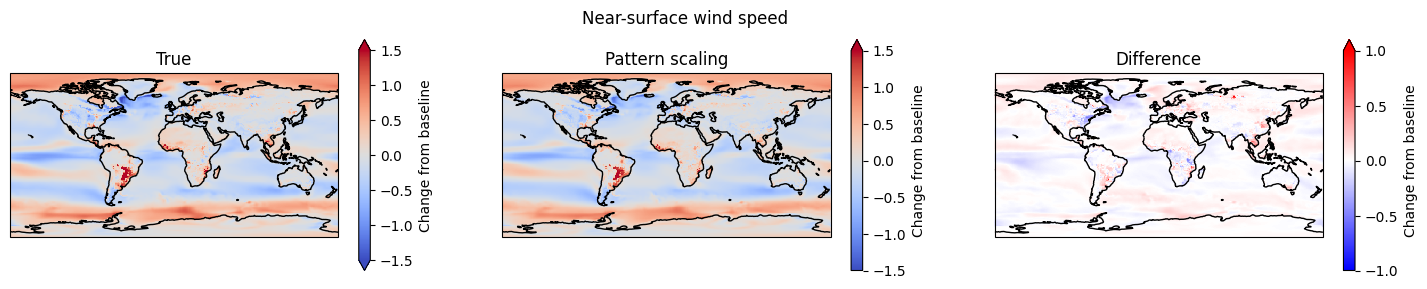

In [67]:
## Near-surface wind speed
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Near-surface wind speed')

# Test
plt.subplot(131, projection=proj)
sfcWind_truth.sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -1.5, vmax=1.5,
                              cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
xr_output["sfcWind"].sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -1.5, vmax=1.5,
                       cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = sfcWind_truth - xr_output["sfcWind"]
plt.subplot(133, projection=proj)
difference.sel(year=slice(2050,None)).mean('year').plot(cmap="bwr", vmin = -1, vmax=1,
                cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

### `ps`

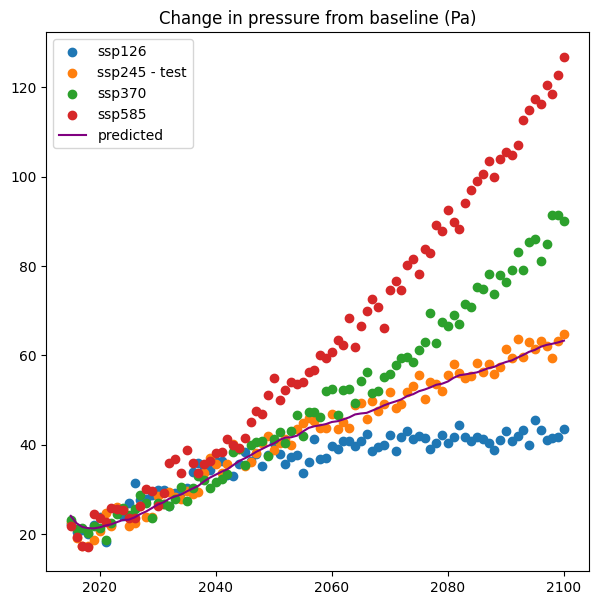

In [96]:
ps_out = xr.DataArray(m_out_ps, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(7, 7))
plt.scatter(x, Y['ps'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, test_Y['ps'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, Y['ps'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.scatter(x, Y['ps'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.plot(x, ps_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in pressure from baseline (Pa)")
plt.legend()
plt.savefig('gmst_ps.jpg', dpi='figure', format=None)

In [49]:
print(f"RMSE: {get_rmse(ps_truth[65:], m_out_ps[65:])}")
print(f"RMSE: {get_rmse(ps_truth[35:], m_out_ps[35:])}")

RMSE: 78.34655201594407
RMSE: 77.1559372443647


[Text(0.5, 1.0, 'Difference')]

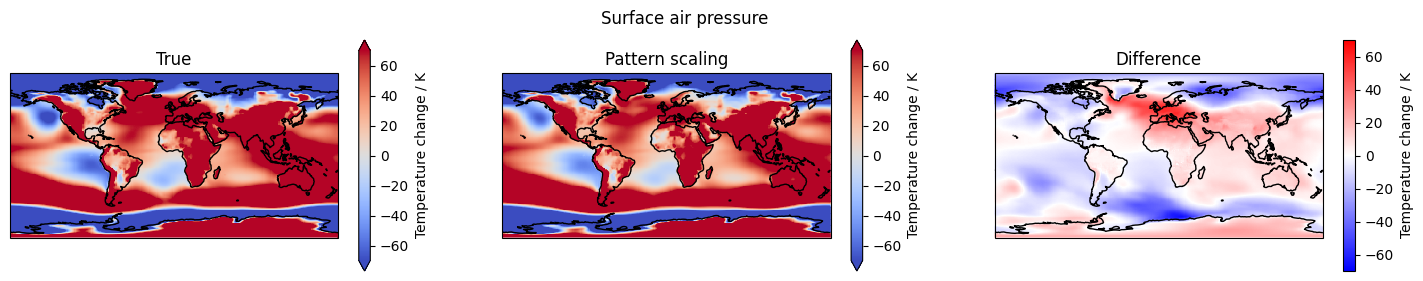

In [50]:
## Surface air pressure
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Surface air pressure')

# Test
plt.subplot(131, projection=proj)
ps_truth.sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm",vmin = -70, vmax=70,
                              cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
xr_output["ps"].sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -70, vmax=70,
                       cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = ps_truth - xr_output["ps"]
plt.subplot(133, projection=proj)
difference.sel(year=slice(2050,None)).mean('year').plot(cmap="bwr", vmin = -70, vmax=70,
                cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')